# Images classification project - CNN with PyTorch on Fashion MNIST dataset

Using PyTorch, this project builds a Convolutional Neural Network (CNN) to categorize photos from the Fashion MNIST dataset.
To improve performance and avoid overfitting, the model is trained using sophisticated approaches such as data augmentation, early halting, and model checkpointing.
TensorBoard is used to log the entire process for visual analysis.

## Load libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from torch.optim.lr_scheduler import StepLR
import copy
import matplotlib.pyplot as plt
import torchvision.utils

2024-06-13 12:06:37.537118: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 12:06:37.564694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Check if model run on GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Load and prepare the data

In [3]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [4]:
# Load datasets
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transforms)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transforms)

In [5]:
# Get the number of classes
num_classes = len(train_data.classes)
print(num_classes)

10


## Defining and training the model

In [6]:
# Define the CNN
class MultiClassImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [7]:
# DataLoaders
batch_size = 10
dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
# Initialize TensorBoard writer
writer = SummaryWriter()

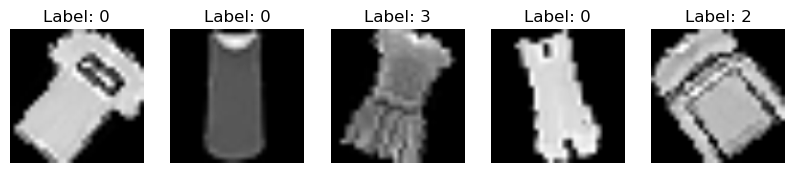

In [9]:
# Display some sample images
def display_sample_images(dataset, num_images=5):
    figure = plt.figure(figsize=(10, 10))
    for index in range(1, num_images + 1):
        img, label = dataset[index]
        plt.subplot(1, num_images, index)
        plt.axis('off')
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f'Label: {label}')
    plt.show()
# Display sample images from training data
display_sample_images(train_data)

In [10]:
# Log sample images to TensorBoard
def log_sample_images(writer, dataloader, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    img_grid = torchvision.utils.make_grid(images[:num_images])
    writer.add_image('Sample Images', img_grid)

# Log sample images from training data
log_sample_images(writer, dataloader_train)

In [11]:
# Define training function with early stopping and model saving
def train_model_with_early_stopping_and_save(optimizer, scheduler, net, dataloader_train, dataloader_val, num_epochs, patience, save_path):
    criterion = nn.CrossEntropyLoss()
    
    best_loss = float('inf')
    best_model_weights = copy.deepcopy(net.state_dict())
    current_patience = patience
    
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0
        num_processed = 0
        
        for features, labels in dataloader_train:
            features, labels = features.to(device), labels.to(device)  # Move to GPU
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * features.size(0)
            num_processed += features.size(0)
    
        scheduler.step()
    
        epoch_loss = running_loss / num_processed
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
        # Log the training loss to TensorBoard
        writer.add_scalar('training loss', epoch_loss, epoch)
        
        # Early stopping check using validation set
        net.eval()
        val_running_loss = 0
        val_num_processed = 0
        
        with torch.no_grad():
            for val_features, val_labels in dataloader_val:
                val_features, val_labels = val_features.to(device), val_labels.to(device)  # Move to GPU
                val_outputs = net(val_features)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item() * val_features.size(0)
                val_num_processed += val_features.size(0)
        
        val_epoch_loss = val_running_loss / val_num_processed
        print(f'Validation Loss: {val_epoch_loss:.4f}')
        
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_model_weights = copy.deepcopy(net.state_dict())
            current_patience = patience
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_loss': best_loss
            }, save_path)
        else:
            current_patience -= 1
            if current_patience == 0:
                print('Early stopping triggered. No improvement in validation loss.')
                break  # Ensure this break is aligned with the if statement
    
    # Load the best model weights
    net.load_state_dict(best_model_weights)
    
    return net

In [12]:
# Train the model
net = MultiClassImageClassifier(num_classes).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
# Define early stopping parameters and save path
patience = 5  # Number of epochs with no improvement after which training will be stopped
save_path = 'fashion_mnist_model.pth'

In [14]:
# Train the model with early stopping and save the best model
net = train_model_with_early_stopping_and_save(optimizer, scheduler, net, dataloader_train, dataloader_test, num_epochs=20, patience=patience, save_path=save_path)

Epoch [0/20], Loss: 0.7054
Validation Loss: 0.5247
Epoch [1/20], Loss: 0.5075
Validation Loss: 0.4514
Epoch [2/20], Loss: 0.4444
Validation Loss: 0.4148
Epoch [3/20], Loss: 0.4129
Validation Loss: 0.3888
Epoch [4/20], Loss: 0.3943
Validation Loss: 0.4075
Epoch [5/20], Loss: 0.3758
Validation Loss: 0.3502
Epoch [6/20], Loss: 0.3634
Validation Loss: 0.3387
Epoch [7/20], Loss: 0.3226
Validation Loss: 0.3010
Epoch [8/20], Loss: 0.3115
Validation Loss: 0.2990
Epoch [9/20], Loss: 0.3022
Validation Loss: 0.2961
Epoch [10/20], Loss: 0.3027
Validation Loss: 0.2906
Epoch [11/20], Loss: 0.2986
Validation Loss: 0.2920
Epoch [12/20], Loss: 0.2948
Validation Loss: 0.2909
Epoch [13/20], Loss: 0.2925
Validation Loss: 0.2859
Epoch [14/20], Loss: 0.2881
Validation Loss: 0.2845
Epoch [15/20], Loss: 0.2854
Validation Loss: 0.2827
Epoch [16/20], Loss: 0.2850
Validation Loss: 0.2833
Epoch [17/20], Loss: 0.2865
Validation Loss: 0.2824
Epoch [18/20], Loss: 0.2849
Validation Loss: 0.2829
Epoch [19/20], Loss: 0

In [15]:
# Evaluate the model
def evaluate_model(net, dataloader_test):
    net.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in dataloader_test:
            outputs = net(features.to(device))
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    
    print(confusion_matrix(all_labels, all_predictions))
    print(classification_report(all_labels, all_predictions))
    
    return all_labels, all_predictions

all_labels, all_predictions = evaluate_model(net, dataloader_test)

Accuracy: 0.9021
Precision: 0.9013
Recall: 0.9021
[[866   1  19  20   4   2  80   0   8   0]
 [  0 977   1  16   1   0   1   0   3   1]
 [ 14   0 860  13  65   0  46   0   2   0]
 [ 20   4  11 903  22   1  38   0   0   1]
 [  2   1  47  32 858   0  56   0   4   0]
 [  0   0   0   0   0 967   0  23   3   7]
 [130   2  72  30  74   2 682   0   8   0]
 [  0   0   0   0   0   6   0 961   1  32]
 [  1   2   2   1   4   1   4   2 982   1]
 [  1   0   0   0   0   3   0  31   0 965]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.85      0.86      0.85      1000
           3       0.89      0.90      0.90      1000
           4       0.83      0.86      0.85      1000
           5       0.98      0.97      0.98      1000
           6       0.75      0.68      0.72      1000
           7       0.94      0.96      0.95      1000
           8       0.97      0.9

In [23]:
# Close TensorBoard writer
writer.close()